# Demo of graph storage in Neo4j
This project demonstrates CRUD operations on a subgraph in Neo4j in the NextGen project.

## Preliminary steps:
* Install Neo4j by following the instructions on the [official website](https://neo4j.com/docs/desktop-manual/current/installation/)
* Install Neosemantics plugin by following the instructions on the [official website](https://neo4j.com/labs/neosemantics/installation/)
* Run Neo4j

In [1]:
import json

import rdflib
import neo4j
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt

## Configure database
Configure the connection to the Neo4J database <span style="color:red">(update it if needed)</span>:

In [2]:
URI = "neo4j://localhost:7687/"
USERNAME = "neo4j"
PASSWORD = "1234567890"

Connect to the database

In [3]:
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

Clean the database  
<span style="color:red">Running this command will delete all data in the database!</span>

In [23]:
with driver.session() as session:
    query = "MATCH (n) OPTIONAL MATCH (n)-[r]-() DELETE n, r;"
    records, summary, keys = driver.execute_query(query)
    print(f"Query counters: {summary.counters}.")

Query counters: {'_contains_updates': True, 'nodes_deleted': 95, 'relationships_deleted': 108}.


Configure the Graph to associate data nods with ontology classes, store an array of values ​​for some attributes, etc. More information [here](https://neo4j.com/labs/neosemantics/5.14/import/).

In [24]:
with driver.session() as session:
    query = """
    CALL n10s.graphconfig.init({
        handleVocabUris: "SHORTEN",
        handleRDFTypes: "LABELS_AND_NODES",
        keepLangTag: true,
        keepCustomDataTypes: true,
        handleMultival: "ARRAY",
        multivalPropList : ["http://www.w3.org/ns/dcat#theme", "http://purl.org/dc/terms/title"]
    });
    """
    records = driver.execute_query(query)
    for record in records.records:
        print(record.data())

{'param': 'handleVocabUris', 'value': 'SHORTEN'}
{'param': 'handleMultival', 'value': 'ARRAY'}
{'param': 'handleRDFTypes', 'value': 'LABELS_AND_NODES'}
{'param': 'keepLangTag', 'value': True}
{'param': 'multivalPropList', 'value': ['http://purl.org/dc/terms/title', 'http://www.w3.org/ns/dcat#theme']}
{'param': 'keepCustomDataTypes', 'value': True}
{'param': 'applyNeo4jNaming', 'value': False}
{'param': 'baseSchemaNamespace', 'value': 'neo4j://graph.schema#'}
{'param': 'baseSchemaPrefix', 'value': 'n4sch'}
{'param': 'classLabel', 'value': 'Class'}
{'param': 'subClassOfRel', 'value': 'SCO'}
{'param': 'dataTypePropertyLabel', 'value': 'Property'}
{'param': 'objectPropertyLabel', 'value': 'Relationship'}
{'param': 'subPropertyOfRel', 'value': 'SPO'}
{'param': 'domainRel', 'value': 'DOMAIN'}
{'param': 'rangeRel', 'value': 'RANGE'}
{'param': 'classNamePropName', 'value': 'name'}
{'param': 'relNamePropName', 'value': 'name'}


Adding Namespace Prefixes to be able to use them in requests.

In [25]:
with driver.session() as session:
    driver.execute_query('CALL n10s.nsprefixes.add("xsd", "http://www.w3.org/2001/XMLSchema#");')
    driver.execute_query('CALL n10s.nsprefixes.add("dcat", "http://www.w3.org/ns/dcat#");')
    driver.execute_query('CALL n10s.nsprefixes.add("dcterms", "http://purl.org/dc/terms/");')
    driver.execute_query('CALL n10s.nsprefixes.add("foaf", "http://xmlns.com/foaf/0.1/");')
    driver.execute_query('CALL n10s.nsprefixes.add("spdx", "http://spdx.org/rdf/terms#");')
    driver.execute_query('CALL n10s.nsprefixes.add("nextgen", "http://nextgen.org/");')
    driver.execute_query('CALL n10s.nsprefixes.add("sh", "http://www.w3.org/ns/shacl#");')

    records = driver.execute_query('CALL n10s.nsprefixes.list();')
    for record in records.records:
        print(record.data())

{'prefix': 'sh', 'namespace': 'http://www.w3.org/ns/shacl#'}
{'prefix': 'nextgen', 'namespace': 'http://nextgen.org/'}
{'prefix': 'spdx', 'namespace': 'http://spdx.org/rdf/terms#'}
{'prefix': 'foaf', 'namespace': 'http://xmlns.com/foaf/0.1/'}
{'prefix': 'dcat', 'namespace': 'http://www.w3.org/ns/dcat#'}
{'prefix': 'xsd', 'namespace': 'http://www.w3.org/2001/XMLSchema#'}
{'prefix': 'dcterms', 'namespace': 'http://purl.org/dc/terms/'}


Import the DCAT-3 ontology

In [26]:
with driver.session() as session:
    query = 'CALL n10s.onto.import.fetch("https://www.w3.org/ns/dcat.ttl", "Turtle");'
    records = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))
    print(record)

<Record prefix='dcterms' namespace='http://purl.org/dc/terms/'>


## Creating a new subgraph

In [27]:
data = {
    "@context": {
        "@base": "http://example.com/base/",
        "xsd": "http://www.w3.org/2001/XMLSchema#",
        "dcat": "http://www.w3.org/ns/dcat#",
        "dcterms": "http://purl.org/dc/terms/",
        "spdx": "http://spdx.org/rdf/terms#",
        "foaf": "http://xmlns.com/foaf/0.1/",
        "nextgen": "http://nextgen.org/",
        "med1": "http://example-med-ontology-1.org/",
        "med2": "http://example-med-ontology-2.org/",
    },
    "@graph": [
        {
            "@id": "catalog-001",
            "@type": "dcat:Catalog",
            "dcterms:identifier": "c1",
            "dcat:dataset": [{"@id": "dataset-001"}, {"@id": "dataset-002"}],
            "dcat:service": [{"@id": "data-service-001"}, {"@id": "data-service-002"}],
        },
        {
            "@id": "dataset-001",
            "@type": "dcat:Dataset",
            "dcterms:identifier": "dataset1",
            "dcterms:title": [
                {
                    "@value": "Example dataset 1",
                    "@language": "en"
                },
                {
                    "@value": "Пример датасета 1",
                    "@language": "ru"
                }
            ],
            "dcterms:issued": "2011-12-05",
            "dcat:theme": ["clinical Data", "general"],
            "dcterms:creator": {"@id": "person-001"},
            "nextgen:isShared": False,
            "dcat:distribution": {"@id": "distribution-001"},
            "med1:sex": "M",
            "med1:age": {
                "@value": "30",
                "@type": "xsd:integer"
            },
            "med2:diagnoses": {"@id": "diagnoses-001"},
        },
        {
            "@id": "distribution-001",
            "@type": "dcat:Distribution",
            "spdx:checksum": {
                "@type": "spdx:Checksum",
                "spdx:algorithm": "sha256",
                "spdx:checksumValue": "3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b84",
            },
            "dcat:byteSize": 5120,
            "dcat:mediaType": "application/csv",
            "dcat:accessService": {"@id": "data-service-001"},
        },
        {
            "@id": "data-service-001",
            "@type": "dcat:DataService",
            "dcat:endpointURL": "http://example.org/dataproduct1",
            "dcat:servesDataset": {"@id": "dataset-001"},
        },
        {
            "@id": "diagnoses-001",
            "@type": "med2:Diagnoses",
            "med2:hasDiagnosis": [{"@id": "diagnosis-001"}, {"@id": "diagnosis-002"}],
        },
        {
            "@id": "diagnosis-001",
            "@type": "med2:Diagnosis",
            "med2:code": "I10",
            "med2:description": "Essential (primary) hypertension",
        },
        {
            "@id": "diagnosis-002",
            "@type": "med2:Diagnosis",
            "med2:code": "E11",
            "med2:description": "Type 2 diabetes mellitus",
        },
        {
            "@id": "dataset-002",
            "@type": "dcat:Dataset",
            "dcterms:identifier": "dataset2",
            "dcterms:title": "Example dataset 2",
            "dcterms:issued": "2024-02-25",
            "dcat:theme": ["clinical data", "general", "another"],
            "dcterms:creator": {"@id": "person-001"},
            "nextgen:isShared": False,
            "dcat:distribution": {"@id": "distribution-002"},
        },
        {
            "@id": "distribution-002",
            "@type": "dcat:Distribution",
            "spdx:checksum": {
                "@type": "spdx:Checksum",
                "spdx:algorithm": "sha256",
                "spdx:checksumValue": "3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b85",
            },
            "dcat:byteSize": 1024,
            "dcat:mediaType": "application/xml",
            "dcat:accessService": {"@id": "data-service-002"},
        },
        {
            "@id": "data-service-002",
            "@type": "dcat:DataService",
            "dcat:endpointURL": "http://example.org/dataproduct2",
            "dcat:servesDataset": {"@id": "dataset-002"},
        },
        {
            "@id": "person-001",
            "@type": "foaf:Person",
            "foaf:name": "Kate Smith",
            "dcterms:identifier": "user1",
        },
    ],
}

Define the function for converting the python dictionary into the text.

In [28]:
def json_to_string(data_json):
    json_str = json.dumps(data_json, ensure_ascii=False)
    escaped_str = json.dumps(json_str)
    return escaped_str

Convert the dictionary into the text using the transformation function and execute a query for data imports in Neo4j using the Neosemantics plugin.

In [29]:
data_str = json_to_string(data)
print(data_str)

with driver.session() as session:
    query = f'CALL n10s.rdf.import.inline({data_str}, "JSON-LD");'
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))
    print(record)

"{\"@context\": {\"@base\": \"http://example.com/base/\", \"xsd\": \"http://www.w3.org/2001/XMLSchema#\", \"dcat\": \"http://www.w3.org/ns/dcat#\", \"dcterms\": \"http://purl.org/dc/terms/\", \"spdx\": \"http://spdx.org/rdf/terms#\", \"foaf\": \"http://xmlns.com/foaf/0.1/\", \"nextgen\": \"http://nextgen.org/\", \"med1\": \"http://example-med-ontology-1.org/\", \"med2\": \"http://example-med-ontology-2.org/\"}, \"@graph\": [{\"@id\": \"catalog-001\", \"@type\": \"dcat:Catalog\", \"dcterms:identifier\": \"c1\", \"dcat:dataset\": [{\"@id\": \"dataset-001\"}, {\"@id\": \"dataset-002\"}], \"dcat:service\": [{\"@id\": \"data-service-001\"}, {\"@id\": \"data-service-002\"}]}, {\"@id\": \"dataset-001\", \"@type\": \"dcat:Dataset\", \"dcterms:identifier\": \"dataset1\", \"dcterms:title\": [{\"@value\": \"Example dataset 1\", \"@language\": \"en\"}, {\"@value\": \"\u041f\u0440\u0438\u043c\u0435\u0440 \u0434\u0430\u0442\u0430\u0441\u0435\u0442\u0430 1\", \"@language\": \"ru\"}], \"dcterms:issued

## Validation at Neo4j level

Import the demo shacl for the DCAT-3 ontology.

In [30]:
with driver.session() as session:
    query = f'CALL n10s.validation.shacl.import.fetch("https://raw.githubusercontent.com/HIRO-MicroDataCenters-BV/demo-store-graph-neo4j/refs/heads/main/data/demo-dcat-shacl.ttl", "Turtle");'
    records = driver.execute_query(query)
    print(records)

EagerResult(records=[<Record target='dcat__Service' propertyOrRelationshipPath='dcat__title' param='sh:datatype' value='http://www.w3.org/2001/XMLSchema#string'>, <Record target='dcat__Catalog' propertyOrRelationshipPath='dcat__description' param='sh:datatype' value='http://www.w3.org/2001/XMLSchema#string'>, <Record target='dcat__Dataset' propertyOrRelationshipPath='dcat__publisher' param='sh:datatype' value='http://www.w3.org/2001/XMLSchema#string'>, <Record target='dcat__Distribution' propertyOrRelationshipPath='dcat__format' param='sh:datatype' value='http://www.w3.org/2001/XMLSchema#string'>, <Record target='dcat__Catalog' propertyOrRelationshipPath='dcat__title' param='sh:datatype' value='http://www.w3.org/2001/XMLSchema#string'>, <Record target='dcat__Distribution' propertyOrRelationshipPath='dcat__accessURL' param='sh:datatype' value='http://www.w3.org/2001/XMLSchema#string'>, <Record target='dcat__Dataset' propertyOrRelationshipPath='dcat__title' param='sh:datatype' value='htt

Display the list of shapes.

In [31]:
with driver.session() as session:
    records = driver.execute_query('CALL n10s.validation.shacl.listShapes();')
    for record in records.records:
        print(record.data())

{'target': 'dcat__Service', 'propertyOrRelationshipPath': 'dcat__title', 'param': 'sh:datatype', 'value': 'http://www.w3.org/2001/XMLSchema#string'}
{'target': 'dcat__Catalog', 'propertyOrRelationshipPath': 'dcat__description', 'param': 'sh:datatype', 'value': 'http://www.w3.org/2001/XMLSchema#string'}
{'target': 'dcat__Dataset', 'propertyOrRelationshipPath': 'dcat__publisher', 'param': 'sh:datatype', 'value': 'http://www.w3.org/2001/XMLSchema#string'}
{'target': 'dcat__Distribution', 'propertyOrRelationshipPath': 'dcat__format', 'param': 'sh:datatype', 'value': 'http://www.w3.org/2001/XMLSchema#string'}
{'target': 'dcat__Catalog', 'propertyOrRelationshipPath': 'dcat__title', 'param': 'sh:datatype', 'value': 'http://www.w3.org/2001/XMLSchema#string'}
{'target': 'dcat__Distribution', 'propertyOrRelationshipPath': 'dcat__accessURL', 'param': 'sh:datatype', 'value': 'http://www.w3.org/2001/XMLSchema#string'}
{'target': 'dcat__Dataset', 'propertyOrRelationshipPath': 'dcat__title', 'param':

Validate the entire graph

In [32]:
with driver.session() as session:
    records = driver.execute_query('CALL n10s.validation.shacl.validate() yield focusNode, nodeType,propertyShape,offendingValue,resultPath,severity;')
    for record in records.records:
        print(record.data())

Upload an invalid subraph

In [33]:
data = {
    "@context": {
        "@base": "http://example.com/base/",
        "dcat": "http://www.w3.org/ns/dcat#",
        "dcterms": "http://purl.org/dc/terms/",
    },
    "@graph": [
        {
            "@id": "catalog-002",
            "@type": "dcat:Catalog",
            "dcterms:identifier": "c2",
            "dcat:title": 111  # Wrong type, must be str
        }
    ]
}

data_str = json_to_string(data)
print(data_str)

with driver.session() as session:
    query = f'CALL n10s.rdf.import.inline({data_str}, "JSON-LD");'
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))
    print(record)
    

"{\"@context\": {\"@base\": \"http://example.com/base/\", \"dcat\": \"http://www.w3.org/ns/dcat#\", \"dcterms\": \"http://purl.org/dc/terms/\"}, \"@graph\": [{\"@id\": \"catalog-002\", \"@type\": \"dcat:Catalog\", \"dcterms:identifier\": \"c2\", \"dcat:title\": 111}]}"
<Record terminationStatus='OK' triplesLoaded=3 triplesParsed=3 namespaces={'ns1': 'http://example-med-ontology-2.org/', 'dcat': 'http://www.w3.org/ns/dcat#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'nextgen': 'http://nextgen.org/', 'ns0': 'http://example-med-ontology-1.org/', 'xsd': 'http://www.w3.org/2001/XMLSchema#', 'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#', 'spdx': 'http://spdx.org/rdf/terms#', 'sh': 'http://www.w3.org/ns/shacl#', 'n4sch': 'neo4j://graph.schema#', 'dcterms': 'http://purl.org/dc/terms/'} extraInfo='' callParams={'singleTx': True}>


Validate the graph again.

In [34]:
with driver.session() as session:
    records = driver.execute_query('CALL n10s.validation.shacl.validate() yield focusNode, nodeType,propertyShape,offendingValue,resultPath,severity;')
    for record in records.records:
        print(record.data())

{'focusNode': 'http://example.com/base/catalog-002', 'nodeType': 'http://www.w3.org/ns/dcat#Catalog', 'propertyShape': 'http://www.w3.org/ns/shacl#DatatypeConstraintComponent', 'offendingValue': 111, 'resultPath': 'http://www.w3.org/ns/dcat#title', 'severity': 'http://www.w3.org/ns/shacl#Violation'}


## Retrieving data

Define a function to visualize a graph

In [18]:
def visualize_result(query_graph, nodes_text_properties=None):
    G = nx.DiGraph()

    if nodes_text_properties is None:
        nodes_text_properties = {}

    labels = {}
    edge_labels = {}

    for node in query_graph.nodes:
        node_labels = list(node.labels)
        
        node_text = None
        for node_label in node_labels:
            display_label = nodes_text_properties.get(node_label, None)
            if display_label is not None:
                node_text = node[display_label]

        if node_text is None:
            node_text = node_labels[0]

        G.add_node(node.element_id, label=node_text)
        labels[node.element_id] = node_text

    for relationship in query_graph.relationships:
        G.add_edge(relationship.start_node.element_id, relationship.end_node.element_id)
        edge_labels[
            (relationship.start_node.element_id, relationship.end_node.element_id)
        ] = relationship.type

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)

    nx.draw(
        G,
        pos,
        with_labels=True,
        labels=labels,
        node_size=2000,
        node_color="lightgray",
        edge_color="black",
        font_size=8,
        font_weight="normal",
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8, font_color="black"
    )

    plt.show()

Retrieve the "Dataset 1" subgraph.

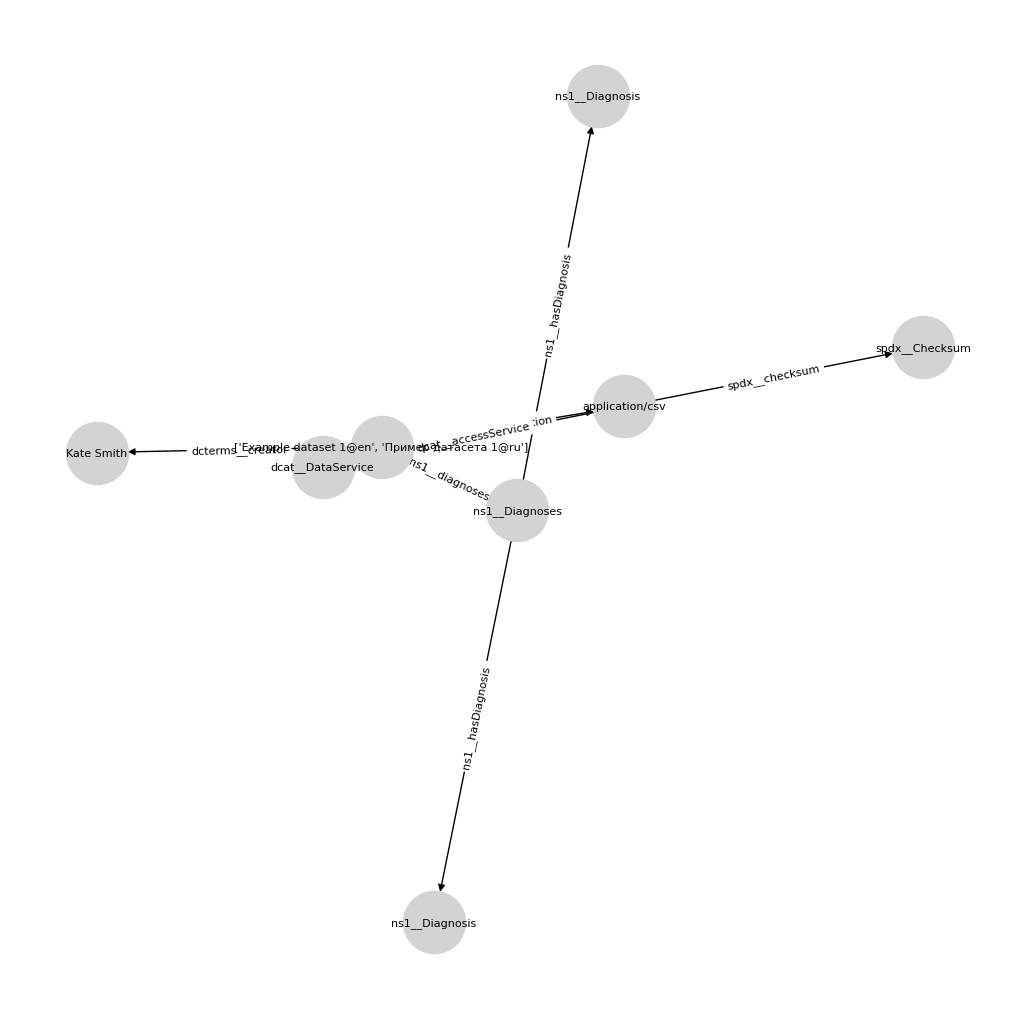

In [35]:
with driver.session() as session:
    query = """
    MATCH (d:dcat__Dataset)-[r*]->(related)
    WHERE d.dcterms__identifier = "dataset1"
    AND all(rel IN r WHERE type(rel) <> "rdf__type")
    RETURN r, related;
    """
    records = driver.execute_query(query, result_transformer_=neo4j.Result.graph)

visualize_result(records, nodes_text_properties={
    "foaf__Person": "foaf__name",
    "dcat__Distribution": "dcat__mediaType",
    "dcat__Dataset": "dcterms__title",
})

Get the Dataset attributes.

In [36]:
with driver.session() as session:
    query = """
    MATCH (d:dcat__Dataset)
    WHERE d.dcterms__identifier = "dataset1"
    RETURN d;
    """
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))

    print("Dataset:")
    for k, v in record.data()["d"].items():
        print(f"{k}: {v}")

Dataset:
dcterms__identifier: dataset1
nextgen__isShared: False
dcterms__issued: 2011-12-05
dcat__theme: ['general', 'clinical Data']
ns0__sex: M
dcterms__title: ['Example dataset 1@en', 'Пример датасета 1@ru']
ns0__age: 30
uri: http://example.com/base/dataset-001


Get the Distribution attributes.

In [37]:
with driver.session() as session:
    query = """
    MATCH (d1:dcat__Dataset)-[]->(d2:dcat__Distribution)
    WHERE d1.dcterms__identifier = "dataset1"
    RETURN d2;
    """
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))

    print("Distribution:")
    for k, v in record.data()["d2"].items():
        print(f"{k}: {v}")

Distribution:
dcat__byteSize: 5120
uri: http://example.com/base/distribution-001
dcat__mediaType: application/csv


Get the Checksum attributes.

In [38]:
with driver.session() as session:
    query = """
    MATCH (d:dcat__Dataset)-[]->(d2:dcat__Distribution)-[]->(cs:spdx__Checksum)
    WHERE d.dcterms__identifier = "dataset1"
    RETURN cs;
    """
    records = driver.execute_query(query)

    print("Checksums:")
    for i in records.records:
        print("--- Checksum:")
        for k, v in i.data()["cs"].items():
            print(f"{k}: {v}")

Checksums:
--- Checksum:
spdx__algorithm: sha256
spdx__checksumValue: 3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b84
uri: bnode://genid-eab37ea530a74b739647b5fcd7644e92236-b0


## Updating the subgraph

Update the dataset title, distribution attributes and checksum.

In [39]:
new_data = {
    "@context": {
        "@base": "http://example.com/base/",
        "dcat": "http://www.w3.org/ns/dcat#",
        "dcterms": "http://purl.org/dc/terms/",
        "spdx": "http://spdx.org/rdf/terms#",
    },
    "@graph": [
        {
            "@id": "dataset-001",
            "@type": "dcat:Dataset",
            "dcterms:identifier": "dataset1",
            "dcterms:title": [
                {
                    "@value": "Exemple de jeu de données 1",
                    "@language": "fr"
                }
            ],
        },
        {
            "@id": "distribution-001",
            "@type": "dcat:Distribution",
            "spdx:checksum": {
                "@type": "spdx:Checksum",
                "spdx:algorithm": "md5",
                "spdx:checksumValue": "3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b00",
            },
            "dcat:byteSize": 2024,
            "dcat:mediaType": "application/json",
        },
    ],
}

Convert the dictionary into the text using the transformation function and execute a query with the new data for data imports in Neo4j using the Neosemantics plugin.

In [40]:
new_data_str = json_to_string(new_data)
print(new_data_str)

with driver.session() as session:
    query = f'CALL n10s.rdf.import.inline({new_data_str}, "JSON-LD");'
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))
    print(record)

"{\"@context\": {\"@base\": \"http://example.com/base/\", \"dcat\": \"http://www.w3.org/ns/dcat#\", \"dcterms\": \"http://purl.org/dc/terms/\", \"spdx\": \"http://spdx.org/rdf/terms#\"}, \"@graph\": [{\"@id\": \"dataset-001\", \"@type\": \"dcat:Dataset\", \"dcterms:identifier\": \"dataset1\", \"dcterms:title\": [{\"@value\": \"Exemple de jeu de donn\u00e9es 1\", \"@language\": \"fr\"}]}, {\"@id\": \"distribution-001\", \"@type\": \"dcat:Distribution\", \"spdx:checksum\": {\"@type\": \"spdx:Checksum\", \"spdx:algorithm\": \"md5\", \"spdx:checksumValue\": \"3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b00\"}, \"dcat:byteSize\": 2024, \"dcat:mediaType\": \"application/json\"}]}"
<Record terminationStatus='OK' triplesLoaded=10 triplesParsed=10 namespaces={'ns1': 'http://example-med-ontology-2.org/', 'dcat': 'http://www.w3.org/ns/dcat#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'nextgen': 'http://nextgen.org/', 'ns0': 'http://example-med-ontology-1.org/', 'xsd': 'http://www.w3.

Retrieve the updated "Dataset 1" subgraph.

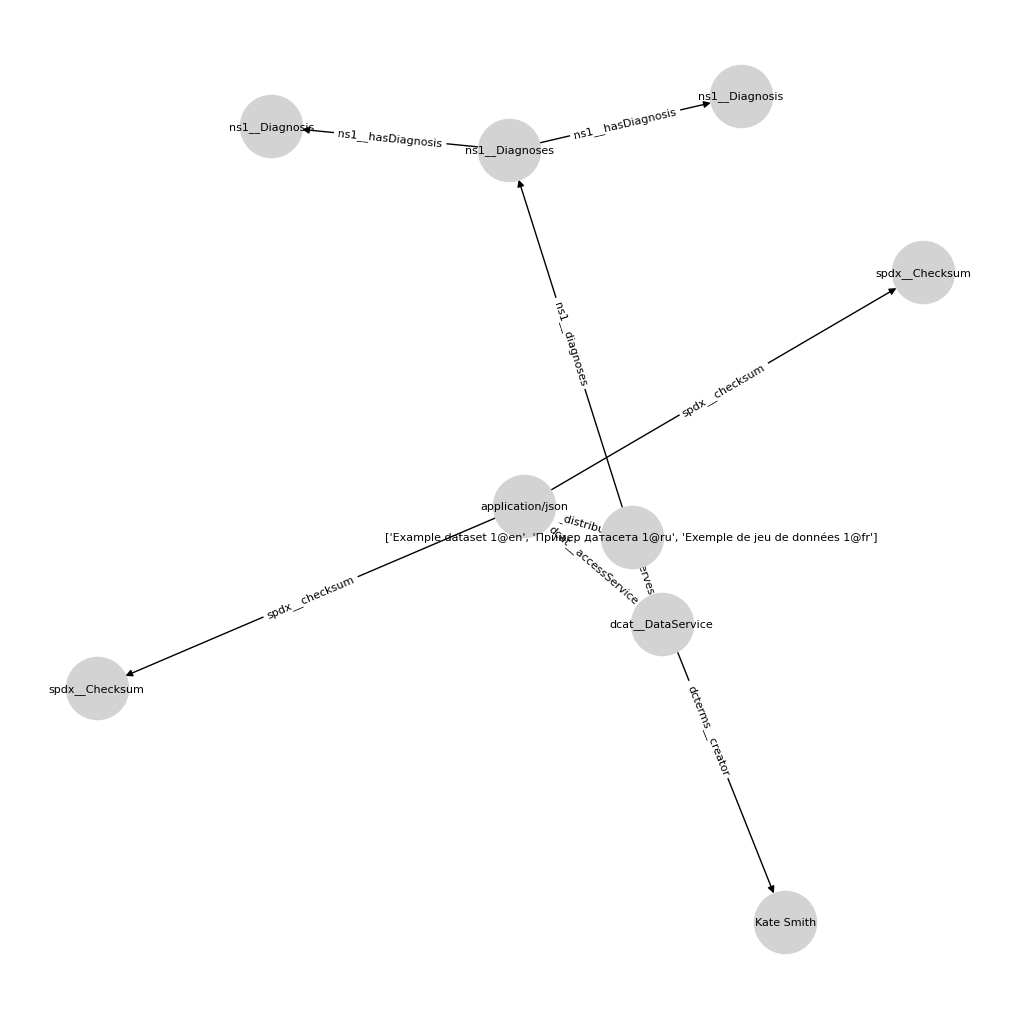

In [41]:
with driver.session() as session:
    query = """
    MATCH (d:dcat__Dataset)-[r*]->(related)
    WHERE d.dcterms__identifier = "dataset1"
    AND all(rel IN r WHERE type(rel) <> "rdf__type")
    RETURN r, related;
    """
    records = driver.execute_query(query, result_transformer_=neo4j.Result.graph)

visualize_result(records, nodes_text_properties={
    "foaf__Person": "foaf__name",
    "dcat__Distribution": "dcat__mediaType",
    "dcat__Dataset": "dcterms__title",
})

Get the updated Dataset attributes.  
The transmitted attribute "title" in the nods Dataset was updated. The rest of the existing attributes of these nodes remain unchanged.

In [42]:
with driver.session() as session:
    query = """
    MATCH (d:dcat__Dataset)
    WHERE d.dcterms__identifier = "dataset1"
    RETURN d;
    """
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))

    print("Dataset:")
    for k, v in record.data()["d"].items():
        print(f"{k}: {v}")

Dataset:
dcterms__identifier: dataset1
nextgen__isShared: False
dcterms__issued: 2011-12-05
dcat__theme: ['general', 'clinical Data']
ns0__sex: M
dcterms__title: ['Example dataset 1@en', 'Пример датасета 1@ru', 'Exemple de jeu de données 1@fr']
ns0__age: 30
uri: http://example.com/base/dataset-001


Get the updated Distribution attributes.  
The transmitted attributes byteSize and mediaType were updated. The rest of the existing attributes of these nodes remain unchanged.

In [43]:
with driver.session() as session:
    query = """
    MATCH (d1:dcat__Dataset)-[]->(d2:dcat__Distribution)
    WHERE d1.dcterms__identifier = "dataset1"
    RETURN d2;
    """
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))

    print("Distribution:")
    for k, v in record.data()["d2"].items():
        print(f"{k}: {v}")

Distribution:
dcat__byteSize: 2024
uri: http://example.com/base/distribution-001
dcat__mediaType: application/json


Get the updated Checksum attributes.  
A new node Checksum was created, because Checksum does not have an id. The previous Checksum node is also present in the graph.

In [44]:
with driver.session() as session:
    query = """
    MATCH (d:dcat__Dataset)-[]->(d2:dcat__Distribution)-[]->(cs:spdx__Checksum)
    WHERE d.dcterms__identifier = "dataset1"
    RETURN cs;
    """
    records = driver.execute_query(query)

    print("Checksums:")
    for i in records.records:
        print("--- Checksum:")
        for k, v in i.data()["cs"].items():
            print(f"{k}: {v}")

Checksums:
--- Checksum:
spdx__algorithm: md5
spdx__checksumValue: 3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b00
uri: bnode://genid-eab37ea530a74b739647b5fcd7644e92245-b0
--- Checksum:
spdx__algorithm: sha256
spdx__checksumValue: 3e23e8160039594a33894f6564e1b1348bb8e482aa04f83e8e39b4e804d19b84
uri: bnode://genid-eab37ea530a74b739647b5fcd7644e92236-b0


*Since we can't guarantee that the user will assign the required node IDs in the domain-specific ontology correctly (so they don't get duplicated during updates), the most reliable way is to delete the entire dataset subgraph and recreate it from scratch.*

## Exporting the subgraph

Define a function to convert RDF to Json-ld.

In [45]:
def convert_to_jsonld(triples, context, base_uri):
    graph = rdflib.Graph()

    for subject, predicate, obj, isLiteral, literalType, literalLang, *rest in triples:
        subject = subject.replace(base_uri, "")
        predicate = predicate.replace(base_uri, "")
        obj = obj.replace(base_uri, "") if isinstance(obj, str) else obj

        if isLiteral:
            if literalLang:
                obj = rdflib.Literal(obj, lang=literalLang)
            elif literalType:
                obj = rdflib.Literal(obj, datatype=rdflib.URIRef(literalType))
            else:
                obj = rdflib.Literal(obj)
        else:
            obj = rdflib.URIRef(obj)

        graph.add(
            (rdflib.URIRef(subject), rdflib.URIRef(predicate), rdflib.Literal(obj))
        )

    context["@base"] = base_uri

    jsonld_data = graph.serialize(format="json-ld", indent=4, context=context)
    return jsonld_data

Extract triplets (RDF) from Neo4j and convert them to Json-ld.

In [46]:
context = {
    'nextgen': 'http://nextgen.org/',
    'spdx': 'http://spdx.org/rdf/terms#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'dcterms': 'http://purl.org/dc/terms/',
    'dcat': 'http://www.w3.org/ns/dcat#',
}

base_uri = "http://example.com/base/"

query = """
    call n10s.rdf.export.cypher('
        MATCH (d:dcat__Dataset)-[r*]-(related)
        WHERE d.dcterms__identifier = "dataset1"
        AND all(rel IN r WHERE type(rel) <> "rdf__type")
        RETURN d, r, related',
        {stream: True, format: 'RDF'}
    )
"""

def fetch_data_from_neo4j(tx):
    result = tx.run(query)
    return list(result)


with driver.session() as session:
    triples = session.execute_read(fetch_data_from_neo4j)
    jsonld_result = convert_to_jsonld(triples, context, base_uri)
    print(jsonld_result)

{
    "@context": {
        "@base": "http://example.com/base/",
        "dcat": "http://www.w3.org/ns/dcat#",
        "dcterms": "http://purl.org/dc/terms/",
        "foaf": "http://xmlns.com/foaf/0.1/",
        "nextgen": "http://nextgen.org/",
        "spdx": "http://spdx.org/rdf/terms#"
    },
    "@graph": [
        {
            "@id": "catalog-001",
            "@type": "http://www.w3.org/ns/dcat#Catalog",
            "dcat:dataset": [
                "dataset-002",
                "dataset-001"
            ],
            "dcat:service": [
                "data-service-001",
                "data-service-002"
            ],
            "dcterms:identifier": "c1"
        },
        {
            "@id": "data-service-002",
            "@type": "http://www.w3.org/ns/dcat#DataService",
            "dcat:endpointURL": "http://example.org/dataproduct2",
            "dcat:servesDataset": "dataset-002"
        },
        {
            "@id": "person-001",
            "@type": "http://xm

## Deleting the subgraph

Delete the relation between Dataset and Person so that the user is not deleted along with the dataset. This is possible because the structural ontology of the catalog is known.

In [47]:
query = """
MATCH (d:dcat__Dataset)-[r:dcterms__creator]->(p:foaf__Person)
WHERE d.dcterms__identifier = "dataset1"
DELETE r
"""

records = driver.execute_query(query)
print(records)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x00000218F391ED20>, keys=[])


Delete the dataset.

In [48]:
query = """
MATCH (d:dcat__Dataset)-[r*]->(related)
WHERE d.dcterms__identifier = "dataset1"
UNWIND r AS rel
DELETE rel
WITH d, collect(related) AS nodes
UNWIND nodes AS node
DETACH DELETE node
DETACH DELETE d
"""

result = driver.execute_query(query)
print(result)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x00000218F3D338F0>, keys=[])


Check if the user still exists.

In [49]:
with driver.session() as session:
    query = """
    MATCH (p:foaf__Person)
    WHERE p.dcterms__identifier = "user1"
    RETURN p;
    """
    record = driver.execute_query(query, result_transformer_=lambda r: r.single(strict=True))

    print("Person:")
    for k, v in record.data()["p"].items():
        print(f"{k}: {v}")
    

Person:
dcterms__identifier: user1
uri: http://example.com/base/person-001
foaf__name: Kate Smith


Updated graph. There is singl dataset.

In [50]:
with driver.session() as session:
    query = """
    MATCH (c:dcat__Catalog)-[r:dcat__dataset]->(d:dcat__Dataset)
    WHERE c.dcterms__identifier = "c1"
    RETURN d;
    """
    records = driver.execute_query(query)

    print("Datasets:")
    for i in records.records:
        print("--- Dataset:")
        for k, v in i.data()["d"].items():
            print(f"{k}: {v}")

Datasets:
--- Dataset:
dcterms__identifier: dataset2
nextgen__isShared: False
dcterms__issued: 2024-02-25
dcat__theme: ['general', 'another', 'clinical data']
dcterms__title: ['Example dataset 2']
uri: http://example.com/base/dataset-002


## Final steps

Close connection

In [51]:
driver.close()